# LODES Data

LEHD Origin-Destination Employment Statistics (LODES) data is a subset of the
[Longitudinal Employer-Household Dynamics (LEHD)](https://lehd.ces.census.gov/data/)
data. The data format is described in detail in
[this pdf](https://lehd.ces.census.gov/doc/help/onthemap/LODESTechDoc.pdf).

Unlike most of the other data sets the U.S. Census Bureau maintains, this one is not
available via the API at https://api.census.gov/data/. Instead, it is available in
compressed csv files from https://lehd.ces.census.gov/data/lodes/LODES8.

But even though
it lives in a different place than most of the rest of the U.S. Census data, it can
now be accessed with the same `censusdis.data.download` interface as the other data
sets. This notebook demonstrates how.

In [21]:
import censusdis.data as ced
import censusdis.maps as cem
from censusdis.states import NJ, NY, NAMES_FROM_IDS
from censusdis.counties.new_jersey import HUDSON
from censusdis.counties.new_york import NEW_YORK

Like all of the other census data sets, each of the LODES data sets has a symbolic name. We
will import several of them here. 

In [2]:
from censusdis.datasets import (
    LODES_OD_MAIN_JT00,
    LODES_OD_AUX_JT00,
    LODES_WAC_S000_JT00,
    LODES_RAC_S000_JT00,
    ACS5,
)

## Workers who work in New Jersey

To access one of the data sets aggregated to a particular geography, we use the familiar `ced.download` method.

In this example, we are looking at the number of jobs held by workers who work in New Jersey.

In [3]:
# These variables are defined in https://lehd.ces.census.gov/doc/help/onthemap/LODESTechDoc.pdf
# They are:
#    C000: Total number of jobs
#    CA01: Number of jobs for workers age 29 or younger
#    CA02: Number of jobs for workers age 30 to 54
#    CA03: Number of jobs for workers age 55 or older
WAC_RAC_VARIABLES = ["C000", "CA01", "CA02", "CA03"]

In [4]:
df_lodes_wac = ced.download(
    # WAC data sets contain Workplace Area Characteristic data, jobs are totaled by work Census Block
    # which can be aggregated up to larger areas like counties or states.
    # S000 means all jobs.
    # JT00 means all jobs.
    dataset=LODES_WAC_S000_JT00,
    vintage=2020,
    download_variables=["C000", "CA01", "CA02", "CA03"],
    # Geometry. Since this is a RAC data set, this is the geometry where workers
    # live, even if they commute to another state to work.
    state=NJ,
)

In [5]:
df_lodes_wac

,STATE,C000,CA01,CA02,CA03
0,34,3678780,699822,1963054,1015904


## Workers who reside in New Jersey.

These are not necessarily the same workers as the last query, because some people work
in a different state than they reside.

In [6]:
# RAC data sets contain Residence Area Characteristic data, jobs are totaled by home Census Block.
# which can be aggregated up to larger areas like counties or states.

df_lodes_rac = ced.download(
    dataset=LODES_RAC_S000_JT00,
    vintage=2020,
    download_variables=WAC_RAC_VARIABLES,
    state=NJ,
)

In [7]:
df_lodes_rac

,STATE,C000,CA01,CA02,CA03
0,34,4009181,773469,2170124,1065588


## The difference

We can compute how many more people reside in New Jersey than work there.

In [8]:
df_lodes_rac[WAC_RAC_VARIABLES] - df_lodes_wac[WAC_RAC_VARIABLES]

,C000,CA01,CA02,CA03
0,330401,73647,207070,49684


## Origin-destination data

### Within a state

The LODES data also contains data sets about where people live and where they work. 
For example, we can see, for all pairs (C1, C2) of counties in New Jersey,
how many people work in C1 and live in C2.

We do this by specifying all counties for the main geography, which for the OD data sets
specifies where they work, and then `home_geography=True` to use the same geography spec
for where they live. 

In the returned data frame, there will be columns STATE and COUNTY for where they work and
STATE_H and COUNTY_H for where they live (_H stands for home.)

In [9]:
df_nj_county_pairs = ced.download(
    dataset=LODES_OD_MAIN_JT00,
    vintage=2020,
    download_variables=["S000"],  # Total number of jobs.
    state=NJ,
    county="*",
    # The geography above refered to where people work. We can also
    # specify an additional geography for where they work. Or, we can
    # pass `True`, which means the same geography spec as the
    # geography above.
    home_geography=True,
)

In [10]:
df_nj_county_pairs

,STATE,COUNTY,STATE_H,COUNTY_H,S000
0,34,001,34,001,69787
1,34,001,34,003,521
2,34,001,34,005,3014
3,34,001,34,007,5160
4,34,001,34,009,4885
...,...,...,...,...,...
436,34,041,34,033,23
437,34,041,34,035,558
438,34,041,34,037,1526
439,34,041,34,039,396


We can use different geography specifications for work and home. Here is a query to find out how many people who
work in Hudson County live in each of the other counties in the state.

In [11]:
df_work_in_hudson_county = ced.download(
    dataset=LODES_OD_MAIN_JT00,
    vintage=2020,
    download_variables=["S000"],  # Total number of jobs.
    state=NJ,
    county=HUDSON,
    home_geography=dict(state=NJ, county="*"),
)

In [12]:
df_work_in_hudson_county

,STATE,COUNTY,STATE_H,COUNTY_H,S000
0,34,017,34,001,849
1,34,017,34,003,27286
2,34,017,34,005,1932
3,34,017,34,007,1717
4,34,017,34,009,240
5,34,017,34,011,508
6,34,017,34,013,24087
7,34,017,34,015,943
8,34,017,34,017,81168
9,34,017,34,019,1088


Now we can do the opposite, and see how many people who live in Hudson County work in each of the
other counties.

In [13]:
df_live_in_hudson_county = ced.download(
    dataset=LODES_OD_MAIN_JT00,
    vintage=2020,
    download_variables=["S000"],  # Total number of jobs.
    state=NJ,
    county="*",
    home_geography=dict(state=NJ, county=HUDSON),
)

In [14]:
df_live_in_hudson_county

,STATE,COUNTY,STATE_H,COUNTY_H,S000
0,34,001,34,017,475
1,34,003,34,017,27779
2,34,005,34,017,1180
3,34,007,34,017,927
4,34,009,34,017,50
5,34,011,34,017,162
6,34,013,34,017,21933
7,34,015,34,017,478
8,34,017,34,017,81168
9,34,019,34,017,448


### Across state lines

In the examples of county-to-county commutes in New Jersey, we used one of the MAIN OD data sets. There are also AUX data sets
that cover workers who commute from state to state.

We can use one of those to look at what states people commute to New Jersey from.

In [15]:
df_work_in_ny = ced.download(
    dataset=LODES_OD_AUX_JT00,
    vintage=2020,
    download_variables=["S000"],  # Total number of jobs.
    state=NY,
    home_geography=dict(state="*"),
)

In [16]:
# Add names so the results are easier to read.
df_work_in_ny["STATE_H_NAME"] = df_work_in_ny["STATE_H"].map(NAMES_FROM_IDS)

In [17]:
df_work_in_ny.nlargest(10, "S000")

,STATE,STATE_H,S000,STATE_H_NAME
30,36,34,501581,New Jersey
6,36,09,97841,Connecticut
37,36,42,68454,Pennsylvania
21,36,25,23050,Massachusetts
20,36,24,9135,Maryland
9,36,12,7603,Florida
4,36,06,7296,California
45,36,51,7064,Virginia
44,36,50,5570,Vermont
32,36,37,5460,North Carolina


### Census Tracts in Manhattan where a people who live in NJ work.

In [18]:
gdf_work_in_manhattan_live_in_nj = ced.download(
    dataset=LODES_OD_AUX_JT00,
    vintage=2020,
    download_variables=["S000"],  # Total number of jobs.
    state=NY,
    county=NEW_YORK,  # This is Manhattan's county.
    tract="*",
    home_geography=dict(state=NJ),
    with_geometry=True,
    remove_water=True,
)

Plot the top tracts on a map. Not surprisingly, they are most concentrated in Midtown and the Financial District, both of which
are well-served by transit (PATH to WTC and NJT to Penn Station).

In [19]:
N = 100
gdf_top_work_in_manhattan_live_in_nj = gdf_work_in_manhattan_live_in_nj.nlargest(
    N, "S000"
)

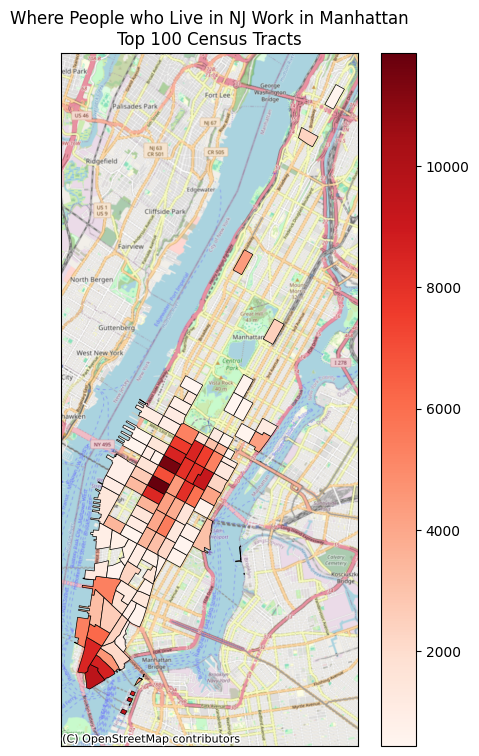

In [20]:
ax = cem.plot_map(
    gdf_top_work_in_manhattan_live_in_nj,
    "S000",
    cmap="Reds",
    edgecolor="black",
    figsize=(6, 9),
    with_background=True,
    legend=True,
    linewidth=0.5,
)

ax.set_title(f"Where People who Live in NJ Work in Manhattan\nTop {N} Census Tracts");